<a href="https://colab.research.google.com/github/MissUnique/MEDVSE-Project/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**

This project presents an innovative deep learning solution for estimating vital signs through smartphone cameras, addressing the growing need for accessible health monitoring, particularly for elder care and disease management. Unlike existing approaches that rely on complex preprocessing steps and hand-crafted features, this solution utilizes a fully convolutional architecture, optimizing computational efficiency and minimizing overfitting risks. The model estimates key vital signs - heart rate (HR), oxygen saturation levels (SpO2), and respiratory rate (RR) - from video input. Tested on a dataset of 62 videos from 35 men and 27 women, it shows promise for on-device smartphone health monitoring deployment without sacrificing accuracy or performance.

# **Importing libraries**

In [ ]:
import torch
from engine import *
from models_builders import *
from models_dataloaders import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


# **Data Overview**


The MTHS dataset was collected to provide PPG signals using a smartphone camera, as few such datasets exist. Key details:

- **Device used**: iPhone 5s (30 fps), with flashlight on.

- **Participants**: 62 total (35 men, 27 women).

- **Sampling**:
    - PPG signal: 30 Hz.
    - Ground truth (Heart Rate & SpO₂): 1 Hz, measured using a pulse oximeter (M70).
    
- **Procedure**: Patients fully covered the camera and flashlight with their fingertips.

# **Data Pre-Processing**

Data pre-processing is a crucial step that enhances data quality and reliability, providing valuable insights into its structure, patterns, and any inconsistencies. This stage helps identify and handle missing or noisy data, normalize values, and prepare the dataset for analysis or modeling. Effective pre-processing enables us to make informed decisions about further steps, ensuring that the dataset is accurate, consistent, and ready for optimal performance in subsequent analysis or machine learning tasks.

**In this section :**

1- Create a Metadata DataFrame

2- Visualize Sample Data


## **MetaData**

In [ ]:
# Create Dictionary
# Number of labels refers to the number of samples extracted from each signal.
Dic = {"patient_ID" : [],"Gender" : [],"number_of_labels" : []}
root_path = "/content/MEDVSE"
patients_metadata = pd.read_excel("MEDVSE/MTHS/gender.xlsx")
time_length = 10

for i in range(67):
    try:
        signals = np.load(f"{root_path}/MTHS/Data/signal_{i}.npy")
        labels = np.load(f"{root_path}/MTHS/Data/label_{i}.npy")

        Dic["patient_ID"].append(i)
        Dic["Gender"].append(patients_metadata[patients_metadata["id"] == i]["gender"].values[0])
        Dic["number_of_labels"].append(labels.shape[0]/time_length)
    except:
        continue

# Meta Data
data = pd.DataFrame.from_dict(Dic)

In [ ]:
data.head(5)

,patient_ID,Gender,number_of_labels
0,2,M,2.6
1,3,F,5.9
2,4,M,7.9
3,5,F,6.0
4,6,M,6.4


## **Visualization**

In [ ]:
def visualize(i):
    assert 2 <= i <= 66, "out of bounds"
    signals = np.load(f"{root_path}/MTHS/Data/signal_{i}.npy")
    plt.plot(list(range(signals.shape[0])),signals[:,0])

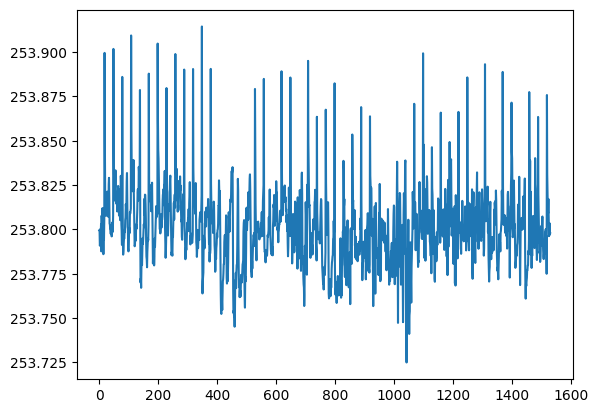

In [ ]:
visualize(8)

Experiments show that data normalization is essential for optimal model performance. Without normalization, larger values can skew the model, as it may mistakenly interpret them as more significant. Normalizing the data helps ensure all features contribute equally. Additionally, larger values can slowdown convergence speed and make the model more computationally intensive.

<Axes: xlabel='Gender'>

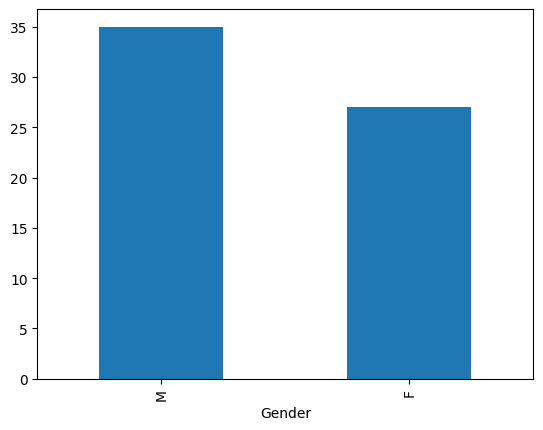

In [ ]:
data["Gender"].value_counts().plot.bar()

From the plot, we can see that the gap between females and males is not very large. Since it is important to split the data such that the distribution of patients is consistent across the sets, this should be taken into account.

# **Important Takeaways from the Paper**

There are several important points to note from the paper:

**Missing Technical Details:** Many technical details are missing in the paper, which led me to consult the code to check the values. However, this was the extent of the information available.

**Methodologies:**
- **Gender distribution:** The author did not ensure that gender was evenly distributed across the three sets. The distribution of gender can significantly impact the model's performance and generalizability.

- **Data Splitting Methodology:** The author splits the data by combining all the signal values into one vector and then processing them into sequences. Afterward, the data is split randomly. ***I believe this approach is flawed and may lead to data leakage.***

**Reason:**
In medical applications, it is better to split the data by patient (depending on the case). In this scenario, each patient’s data should be assigned to either the training, validation, or testing set, with no overlap between them. Assigning each patient’s data to only one set prevents data leakage by avoiding shared patterns or rhythms, which could lead to artificially high performance.

As  a researcher, I prioritize evaluating methodologies from papers carefully to ensure accuracy. While the task at hand is to replicate the paper’s results, I’ll use a more appropriate data-splitting approach, while preserving the original models without modifications.


## **Data Splitting**

**In this section,**

- I will split the data such that each patient's data is assigned to only one section (either training, validation, or testing).

- I will ensure that gender is equally distributed across the three sets.

- I will use a standard practice for data distribution (70% training, 15% validation, and 15% testing) as the proposed 80%, 4%, and 16% distribution in the paper provides insufficient validation data for this small dataset. That way, the model's performance is not assessed properly.

In [ ]:
total_labels = data['number_of_labels'].sum()

train_size = int(total_labels * 0.7)
val_size = int(total_labels * 0.15)
test_size = total_labels - train_size - val_size

# Shuffle the data randomly (to ensure randomness in patient assignment)
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign patients to the sets based on cumulative labels
train_data = []
val_data = []
test_data = []

cumulative_labels = 0

# assign to training set first
for index, row in data_shuffled.iterrows():
    cumulative_labels += row['number_of_labels']
    if cumulative_labels <= train_size:
        train_data.append(row)
    elif cumulative_labels <= train_size + val_size:
        val_data.append(row)
    else:
        test_data.append(row)

# Convert back to DataFrames
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

# Optionally, save the splits to CSV
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)



Training Data:
    patient_ID Gender  number_of_labels
0           55      M               6.0
1           61      F               6.2
2            2      M               2.6
3           62      F               6.0
4            7      M               6.1
5           53      F               6.0
6           21      M              11.9
7           14      M              11.9
8           30      M              11.9
9           64      F               6.2
10          35      M               6.0
11          11      F               5.9
12          52      F               6.0
13          15      M               6.1
14          38      F               6.0
15          39      F               6.0
16           5      F               6.0
17          22      M              12.2
18          59      F               6.0
19          10      M               6.0
20           8      M               5.1
21          36      M               6.0
22           6      M               6.4
23          50      F   

In [ ]:
train_patients = set(train_data['patient_ID'])
val_patients = set(val_data['patient_ID'])
test_patients = set(test_data['patient_ID'])

# To make sure that there is no overlap across the sets
train_val_overlap = train_patients.intersection(val_patients)
train_test_overlap = train_patients.intersection(test_patients)
val_test_overlap = val_patients.intersection(test_patients)

# Print the results of the overlap check
print("\nOverlap Checks:")
print(f"Overlap between training and validation sets: {train_val_overlap}")
print(f"Overlap between training and test sets: {train_test_overlap}")
print(f"Overlap between validation and test sets: {val_test_overlap}")


Overlap Checks:
Overlap between training and validation sets: set()
Overlap between training and test sets: set()
Overlap between validation and test sets: set()


This step ensured that there was no overlap between the sets, ensuring data integrity and preventing any data leakage.

<Axes: xlabel='Gender'>

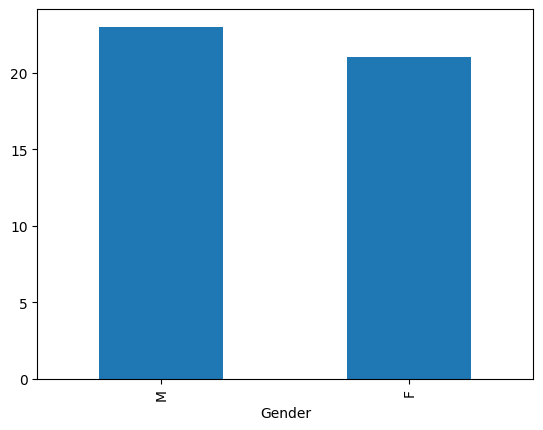

In [ ]:
train_data["Gender"].value_counts().plot.bar()

<Axes: xlabel='Gender'>

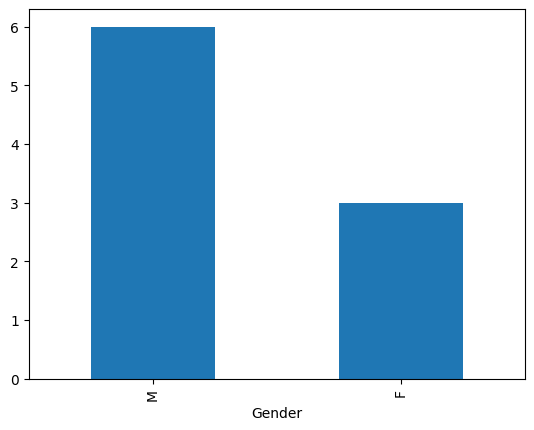

In [ ]:
val_data["Gender"].value_counts().plot.bar()

<Axes: xlabel='Gender'>

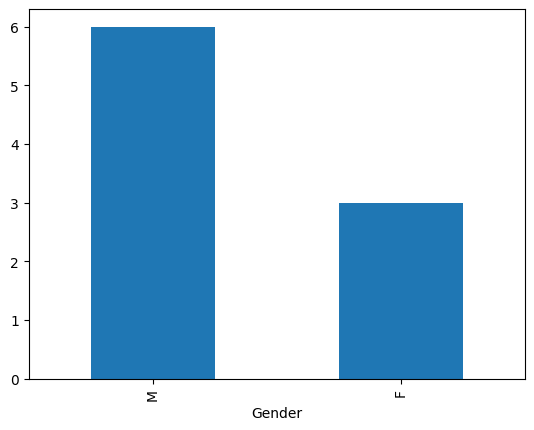

In [ ]:
test_data["Gender"].value_counts().plot.bar()

The gender distribution in the training set is balanced, which is beneficial for the model’s generalization. Additionally, the gender distribution is equal in both the testing and validation sets, as they reflect real-world conditions. Therefore, the data split is appropriate.

# **Data Loader and Key Considerations from the Paper**

In the original model, a `StandardScaler` layer was used to standardize each batch individually rather than applying standardization across the entire dataset.
 ***This approach created two key issues:***



**Batch-Specific Standardization**

The model applied standardization to each batch separately rather than using statistics from the entire dataset. This inconsistent scaling across batches could lead to instability in training and evaluation because the model was trained on data that lacked a consistent distribution.



**Data Leakage Due to Incorrect Standardization**

The authors incorrectly standardized the validation and test sets using their respective means and standard deviations. This resulted in ***data leakage***, as the model indirectly accessed information from the validation and test sets before evaluation, violating a fundamental rule in machine learning.

For robust and unbiased model evaluation, only the statistics from the training set should be used to standardize all data, ensuring that the model does not gain insight into unseen data.



# **Correction and Improved Data Integrity**

To address these issues, we implemented the following corrective measures:

**1. Consistent Scaling Across the Dataset**
We standardized all data using the mean and standard deviation derived solely from the training set, ensuring that the training, validation, and test sets shared a consistent distribution.

**2. Prevention of Data Leakage**
By exclusively using the training set statistics for standardization, we eliminated data leakage, maintaining the integrity of model evaluation. This approach aligns with best practices in machine learning and better simulates real-world conditions, where the model has no access to validation or test data statistics.

These adjustments prevent data leakage and create a more robust and reliable evaluation pipeline for the model, providing a fair assessment of its performance on unseen data.


# **Data Loader**

In [ ]:

train_csv = "train_data.csv"
val_csv = "val_data.csv"
test_csv = "test_data.csv"
root_path = "/content/MEDVSE"
dwn_factor = 2
time_length = 10
mode = "hr"
batch_size = 32

train_loader, val_loader, test_loader = data_loader(train_csv, val_csv, test_csv, root_path, dwn_factor, time_length, batch_size=32, mode="hr")


PPG batch shape: torch.Size([32, 150, 3])
Label batch shape: torch.Size([32])


# **Modelling**

- All the models were created and placed in the model builder file to be reviewed.
- I added `stopping criteria` in the training to prevent the model from overfitting.

## **Target HR**

## **Base Model**

In [ ]:
Base_model = BaseModel()
optimizer = torch.optim.Adam(Base_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Base_model=Base_model.to(device)

In [ ]:
train(Base_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=5)

 35%|███▌      | 7/20 [00:00<00:00, 36.32it/s]


Epoch 1 | Train MSE: 0.4481, Train MAE: 0.5213, Train RMSE: 0.6694 | Test MSE: 0.5005, Test MAE: 0.5664, Test RMSE: 0.7075

Epoch 2 | Train MSE: 0.4633, Train MAE: 0.5317, Train RMSE: 0.6807 | Test MSE: 0.4732, Test MAE: 0.5545, Test RMSE: 0.6879

Epoch 3 | Train MSE: 0.5003, Train MAE: 0.5486, Train RMSE: 0.7073 | Test MSE: 0.4847, Test MAE: 0.5630, Test RMSE: 0.6962

Epoch 4 | Train MSE: 0.4682, Train MAE: 0.5311, Train RMSE: 0.6842 | Test MSE: 0.5252, Test MAE: 0.5861, Test RMSE: 0.7247

Epoch 5 | Train MSE: 0.4852, Train MAE: 0.5451, Train RMSE: 0.6966 | Test MSE: 0.5028, Test MAE: 0.5754, Test RMSE: 0.7091

Epoch 6 | Train MSE: 0.4475, Train MAE: 0.5323, Train RMSE: 0.6690 | Test MSE: 0.5029, Test MAE: 0.5732, Test RMSE: 0.7092

Epoch 7 | Train MSE: 0.5125, Train MAE: 0.5657, Train RMSE: 0.7159 | Test MSE: 0.5019, Test MAE: 0.5742, Test RMSE: 0.7084

Epoch 8 | Train MSE: 0.4856, Train MAE: 0.5452, Train RMSE: 0.6968 | Test MSE: 0.5072, Test MAE: 0.5752, Test RMSE: 0.7122
Early st

{'train_loss': [0.4472207546234131,
  0.4618967443704605,
  0.4978107541799545,
  0.46600645780563354,
  0.4851595968008041,
  0.4471567213535309,
  0.5102064281702041,
  0.4875621169805527],
 'train_mse': [np.float32(0.4480644),
  np.float32(0.46329513),
  np.float32(0.500282),
  np.float32(0.46817988),
  np.float32(0.48524335),
  np.float32(0.44752687),
  np.float32(0.5124577),
  np.float32(0.48557213)],
 'train_mae': [np.float32(0.52125055),
  np.float32(0.5317244),
  np.float32(0.5485799),
  np.float32(0.53106457),
  np.float32(0.5450788),
  np.float32(0.532346),
  np.float32(0.5656732),
  np.float32(0.54517347)],
 'train_rmse': [np.float32(0.66937613),
  np.float32(0.68065786),
  np.float32(0.70730615),
  np.float32(0.6842367),
  np.float32(0.6965941),
  np.float32(0.6689745),
  np.float32(0.7158615),
  np.float32(0.69683003)],
 'test_loss': [0.46298383673032123,
  0.4826989571253459,
  0.4369609554608663,
  0.5636711716651917,
  0.5202862222989401,
  0.46266178290049237,
  0.5528

In [ ]:
test_results = evaluate_model(Base_model,test_loader,loss_fn,device)

## **FCN**

- While the task was to replicate the original paper's implementation, I made some modifications based on common practices in CNN architectures. Specifically, I noticed that the paper used a **linear activation function** following the convolutional layers, which is not typical in modern CNN designs. To align with standard practices, I replaced the **linear activation** with **ReLU (Rectified Linear Unit)**, as it is widely used to introduce non-linearity and improve the model's performance.

In [ ]:
FCN_model = FCN()
optimizer = torch.optim.Adam(FCN_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FCN_model=FCN_model.to(device)


In [ ]:
train(FCN_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=5)

 35%|███▌      | 7/20 [00:00<00:00, 34.87it/s]


Epoch 1 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 2 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 3 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 4 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 5 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 6 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 7 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 8 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 9

 45%|████▌     | 9/20 [00:00<00:00, 30.79it/s]


Epoch 10 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437
Early stopping triggered after 10 epochs.


{'train_loss': [0.5517741918563843,
  0.5363071650266648,
  0.5375874876976013,
  0.5368762105703354,
  0.5400371670722961,
  0.5396159157156944,
  0.5448139786720276,
  0.5469474822282792,
  0.5395971715450287,
  0.53796366751194],
 'train_mse': [np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.53993154),
  np.float32(0.5399315),
  np.float32(0.53993154),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315)],
 'train_mae': [np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733)],
 'train_rmse': [np.float32(0.7348003),
  np.float32(0.7348003),
  np.float32(0.73480034),
  np.float32(0.7348003),
  np.float32(0.73480034),
  np.float32(0.7348003),
  np.float32(0.7348003),
  np.float32(0.7348003),
  np.float3

In [ ]:
test_results = evaluate_model(FCN_model,test_loader,loss_fn,device)

## **Residual**

In [ ]:
Residual_model = Residual()
optimizer = torch.optim.Adam(Residual_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Residual_model=Residual_model.to(device)

In [ ]:
train(Residual_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

 30%|███       | 6/20 [00:00<00:00, 25.18it/s]


Epoch 1 | Train MSE: 0.9382, Train MAE: 0.7457, Train RMSE: 0.9686 | Test MSE: 1.2191, Test MAE: 0.8189, Test RMSE: 1.1041

Epoch 2 | Train MSE: 0.9227, Train MAE: 0.7260, Train RMSE: 0.9606 | Test MSE: 1.1819, Test MAE: 0.8172, Test RMSE: 1.0872

Epoch 3 | Train MSE: 0.9327, Train MAE: 0.7422, Train RMSE: 0.9658 | Test MSE: 1.1831, Test MAE: 0.8170, Test RMSE: 1.0877

Epoch 4 | Train MSE: 0.9333, Train MAE: 0.7274, Train RMSE: 0.9661 | Test MSE: 1.2477, Test MAE: 0.8461, Test RMSE: 1.1170

Epoch 5 | Train MSE: 0.9390, Train MAE: 0.7485, Train RMSE: 0.9690 | Test MSE: 1.0945, Test MAE: 0.7732, Test RMSE: 1.0462

Epoch 6 | Train MSE: 0.9297, Train MAE: 0.7448, Train RMSE: 0.9642 | Test MSE: 1.1595, Test MAE: 0.8089, Test RMSE: 1.0768

Epoch 7 | Train MSE: 0.9256, Train MAE: 0.7345, Train RMSE: 0.9621 | Test MSE: 1.2776, Test MAE: 0.8482, Test RMSE: 1.1303


 35%|███▌      | 7/20 [00:00<00:00, 21.99it/s]


Epoch 8 | Train MSE: 0.9182, Train MAE: 0.7248, Train RMSE: 0.9582 | Test MSE: 1.1759, Test MAE: 0.8110, Test RMSE: 1.0844
Early stopping triggered after 8 epochs.


{'train_loss': [0.9349198043346405,
  0.9264001190662384,
  0.9376870512962341,
  0.9319487810134888,
  0.9484288275241852,
  0.9337440729141235,
  0.9270330131053924,
  0.9177263855934144],
 'train_mse': [np.float32(0.93822366),
  np.float32(0.92273855),
  np.float32(0.93273073),
  np.float32(0.9332827),
  np.float32(0.93900096),
  np.float32(0.9296553),
  np.float32(0.92562133),
  np.float32(0.91816336)],
 'train_mae': [np.float32(0.74566257),
  np.float32(0.72600573),
  np.float32(0.74221206),
  np.float32(0.72735536),
  np.float32(0.74845725),
  np.float32(0.7448431),
  np.float32(0.73452795),
  np.float32(0.7248488)],
 'train_rmse': [np.float32(0.96861947),
  np.float32(0.9605928),
  np.float32(0.96577984),
  np.float32(0.9660656),
  np.float32(0.9690206),
  np.float32(0.9641864),
  np.float32(0.96209216),
  np.float32(0.9582084)],
 'test_loss': [1.1900544166564941,
  1.269875407218933,
  1.1081950267155964,
  1.2741739749908447,
  1.0247689485549927,
  1.051170527935028,
  1.1974

In [ ]:
test_results = evaluate_model(Residual_model,test_loader,loss_fn,device)

## **Convnext**

In [ ]:
Convnext_Model = ModifiedConvnextModel()
optimizer = torch.optim.Adam(Convnext_Model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model=Convnext_Model.to(device)


In [ ]:
train(Convnext_Model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

  5%|▌         | 1/20 [00:00<00:06,  2.76it/s]


Epoch 1 | Train MSE: 0.5572, Train MAE: 0.5517, Train RMSE: 0.7465 | Test MSE: 0.1872, Test MAE: 0.3344, Test RMSE: 0.4327


 10%|█         | 2/20 [00:00<00:06,  2.88it/s]


Epoch 2 | Train MSE: 0.5468, Train MAE: 0.5578, Train RMSE: 0.7395 | Test MSE: 0.1908, Test MAE: 0.3324, Test RMSE: 0.4368


 15%|█▌        | 3/20 [00:01<00:05,  2.90it/s]


Epoch 3 | Train MSE: 0.5395, Train MAE: 0.5411, Train RMSE: 0.7345 | Test MSE: 0.2098, Test MAE: 0.3398, Test RMSE: 0.4580


 15%|█▌        | 3/20 [00:01<00:07,  2.18it/s]


Epoch 4 | Train MSE: 0.5440, Train MAE: 0.5348, Train RMSE: 0.7376 | Test MSE: 0.1922, Test MAE: 0.3323, Test RMSE: 0.4384
Early stopping triggered after 4 epochs.


{'train_loss': [0.5604639574885368,
  0.5448332369327545,
  0.537423774600029,
  0.5459811180830002],
 'train_mse': [np.float32(0.5571916),
  np.float32(0.5468425),
  np.float32(0.53953505),
  np.float32(0.543992)],
 'train_mae': [np.float32(0.55174375),
  np.float32(0.557812),
  np.float32(0.5411469),
  np.float32(0.53478104)],
 'train_rmse': [np.float32(0.7464527),
  np.float32(0.739488),
  np.float32(0.7345305),
  np.float32(0.7375581)],
 'test_loss': [0.16007882232467333,
  0.17058504124482474,
  0.20007852713267008,
  0.20579007267951965],
 'test_mse': [np.float32(0.18720722),
  np.float32(0.19079141),
  np.float32(0.20975077),
  np.float32(0.19222404)],
 'test_mae': [np.float32(0.33438578),
  np.float32(0.33235347),
  np.float32(0.33982173),
  np.float32(0.3322981)],
 'test_rmse': [np.float32(0.4326745),
  np.float32(0.43679675),
  np.float32(0.45798555),
  np.float32(0.43843362)]}

In [ ]:
test_results = evaluate_model(Convnext_Model,test_loader,loss_fn,device)


Evaluation Results: Test Loss (MSE): 0.6693 | Test MSE: 0.6693 | Test MAE: 0.7181 | Test RMSE: 0.8181


# **Target Spo2**

In [ ]:
train_csv = "train_data.csv"
val_csv = "val_data.csv"
test_csv = "test_data.csv"
root_path = "/content/MEDVSE"
dwn_factor = 2
time_length = 10
mode = "spo2"  # Choose "hr" or "spo2" based on mode
batch_size = 32

train_loader, val_loader, test_loader = data_loader(train_csv, val_csv, test_csv,root_path,dwn_factor,time_length,batch_size=32,mode="spo2")


PPG batch shape: torch.Size([32, 150, 3])
Label batch shape: torch.Size([32])


## **Base Model**

In [ ]:
Base_model = BaseModel()
optimizer = torch.optim.Adam(Base_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Base_model=Base_model.to(device)

In [ ]:
train(Base_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

 30%|███       | 6/20 [00:00<00:00, 33.58it/s]


Epoch 1 | Train MSE: 0.7491, Train MAE: 0.6587, Train RMSE: 0.8655 | Test MSE: 0.2650, Test MAE: 0.3683, Test RMSE: 0.5148

Epoch 2 | Train MSE: 0.6459, Train MAE: 0.6196, Train RMSE: 0.8037 | Test MSE: 0.2580, Test MAE: 0.3641, Test RMSE: 0.5079

Epoch 3 | Train MSE: 0.5703, Train MAE: 0.5755, Train RMSE: 0.7552 | Test MSE: 0.2242, Test MAE: 0.3436, Test RMSE: 0.4735

Epoch 4 | Train MSE: 0.5189, Train MAE: 0.5344, Train RMSE: 0.7203 | Test MSE: 0.1964, Test MAE: 0.3309, Test RMSE: 0.4431

Epoch 5 | Train MSE: 0.4570, Train MAE: 0.4996, Train RMSE: 0.6760 | Test MSE: 0.2456, Test MAE: 0.3884, Test RMSE: 0.4956

Epoch 6 | Train MSE: 0.4810, Train MAE: 0.5262, Train RMSE: 0.6935 | Test MSE: 0.2311, Test MAE: 0.3693, Test RMSE: 0.4808

Epoch 7 | Train MSE: 0.4574, Train MAE: 0.4943, Train RMSE: 0.6763 | Test MSE: 0.4411, Test MAE: 0.5320, Test RMSE: 0.6641
Early stopping triggered after 7 epochs.


{'train_loss': [0.7453103840351105,
  0.6420182347297668,
  0.5679320305585861,
  0.5206698209047318,
  0.45552785098552706,
  0.4822408065199852,
  0.4551997721195221],
 'train_mse': [np.float32(0.74913734),
  np.float32(0.64590836),
  np.float32(0.5703281),
  np.float32(0.5188824),
  np.float32(0.4570328),
  np.float32(0.48099557),
  np.float32(0.45737293)],
 'train_mae': [np.float32(0.6587113),
  np.float32(0.6196113),
  np.float32(0.57550645),
  np.float32(0.53440887),
  np.float32(0.49955565),
  np.float32(0.52620995),
  np.float32(0.494339)],
 'train_rmse': [np.float32(0.8655272),
  np.float32(0.80368423),
  np.float32(0.7552007),
  np.float32(0.72033495),
  np.float32(0.676042),
  np.float32(0.6935384),
  np.float32(0.67629355)],
 'test_loss': [0.260766198237737,
  0.2519429326057434,
  0.27840013802051544,
  0.2380218207836151,
  0.25099340081214905,
  0.24397795895735422,
  0.41090791424115497],
 'test_mse': [np.float32(0.26500073),
  np.float32(0.25795832),
  np.float32(0.224

In [ ]:
test_results = evaluate_model(Base_model,test_loader,loss_fn,device)

## **FCN**

In [ ]:
FCN_model = FCN()
optimizer = torch.optim.Adam(FCN_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FCN_model=FCN_model.to(device)

In [ ]:
train(FCN_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

 30%|███       | 6/20 [00:00<00:00, 35.46it/s]


Epoch 1 | Train MSE: 0.5461, Train MAE: 0.5368, Train RMSE: 0.7390 | Test MSE: 0.2088, Test MAE: 0.3393, Test RMSE: 0.4570

Epoch 2 | Train MSE: 0.5403, Train MAE: 0.5391, Train RMSE: 0.7350 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 3 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 4 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 5 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 6 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437

Epoch 7 | Train MSE: 0.5399, Train MAE: 0.5424, Train RMSE: 0.7348 | Test MSE: 0.1969, Test MAE: 0.3338, Test RMSE: 0.4437
Early stopping triggered after 7 epochs.


{'train_loss': [0.5474640101194381,
  0.5370516926050186,
  0.5392898738384246,
  0.5407205134630203,
  0.5429433465003968,
  0.5412034809589386,
  0.5457655996084213],
 'train_mse': [np.float32(0.5460572),
  np.float32(0.5402644),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315),
  np.float32(0.5399315)],
 'train_mae': [np.float32(0.536844),
  np.float32(0.5390522),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733),
  np.float32(0.54240733)],
 'train_rmse': [np.float32(0.73895687),
  np.float32(0.73502684),
  np.float32(0.7348003),
  np.float32(0.7348003),
  np.float32(0.7348003),
  np.float32(0.7348003),
  np.float32(0.7348003)],
 'test_loss': [0.2154795527458191,
  0.19976061085859934,
  0.21158682803312936,
  0.18491719663143158,
  0.1949275036652883,
  0.23195196191469827,
  0.19269994894663492],
 'test_mse': [np.float32(0.20881581),
  np.float32(0.19690627),
  np.float32(0.19690

In [ ]:
test_results = evaluate_model(FCN_model,test_loader,loss_fn,device)

## **Residual**

In [ ]:
Residual_model = Residual()
optimizer = torch.optim.Adam(Residual_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Residual_model=Residual_model.to(device)

In [ ]:
train(Residual_model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

 15%|█▌        | 3/20 [00:00<00:00, 25.58it/s]


Epoch 1 | Train MSE: 0.5494, Train MAE: 0.5499, Train RMSE: 0.7412 | Test MSE: 0.2139, Test MAE: 0.3418, Test RMSE: 0.4624

Epoch 2 | Train MSE: 0.5417, Train MAE: 0.5385, Train RMSE: 0.7360 | Test MSE: 0.1923, Test MAE: 0.3310, Test RMSE: 0.4385

Epoch 3 | Train MSE: 0.5406, Train MAE: 0.5466, Train RMSE: 0.7353 | Test MSE: 0.1938, Test MAE: 0.3333, Test RMSE: 0.4402

Epoch 4 | Train MSE: 0.5344, Train MAE: 0.5482, Train RMSE: 0.7310 | Test MSE: 0.1847, Test MAE: 0.3307, Test RMSE: 0.4297

Epoch 5 | Train MSE: 0.5278, Train MAE: 0.5434, Train RMSE: 0.7265 | Test MSE: 0.1971, Test MAE: 0.3362, Test RMSE: 0.4440

Epoch 6 | Train MSE: 0.5337, Train MAE: 0.5359, Train RMSE: 0.7306 | Test MSE: 0.1933, Test MAE: 0.3322, Test RMSE: 0.4397


 35%|███▌      | 7/20 [00:00<00:00, 24.90it/s]


Epoch 7 | Train MSE: 0.5306, Train MAE: 0.5479, Train RMSE: 0.7284 | Test MSE: 0.1869, Test MAE: 0.3461, Test RMSE: 0.4323

Epoch 8 | Train MSE: 0.5290, Train MAE: 0.5464, Train RMSE: 0.7273 | Test MSE: 0.1985, Test MAE: 0.3339, Test RMSE: 0.4455
Early stopping triggered after 8 epochs.


{'train_loss': [0.5466023594141006,
  0.5388517916202545,
  0.5374424159526825,
  0.5331287682056427,
  0.5255853563547135,
  0.5340767562389374,
  0.5276687711477279,
  0.5274829924106598],
 'train_mse': [np.float32(0.54935795),
  np.float32(0.54171085),
  np.float32(0.5406088),
  np.float32(0.5344253),
  np.float32(0.5278183),
  np.float32(0.5337191),
  np.float32(0.5305755),
  np.float32(0.5290187)],
 'train_mae': [np.float32(0.5499335),
  np.float32(0.5384646),
  np.float32(0.54658043),
  np.float32(0.548204),
  np.float32(0.54337823),
  np.float32(0.5358583),
  np.float32(0.5479471),
  np.float32(0.5463728)],
 'train_rmse': [np.float32(0.74118686),
  np.float32(0.7360101),
  np.float32(0.7352611),
  np.float32(0.731044),
  np.float32(0.72651106),
  np.float32(0.73056084),
  np.float32(0.72840613),
  np.float32(0.7273367)],
 'test_loss': [0.2526065955559413,
  0.20639986793200174,
  0.22887195150057474,
  0.2082704504330953,
  0.17028694351514181,
  0.2034970074892044,
  0.19843778

In [ ]:
test_results = evaluate_model(Residual_model,test_loader,loss_fn,device)

## **Convnext**

In [ ]:
Convnext_Model = ModifiedConvnextModel()
optimizer = torch.optim.Adam(Convnext_Model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Model=Convnext_Model.to(device)

In [ ]:
train(Convnext_Model,optimizer,20,device,loss_fn,train_loader,val_loader,patience=3)

  5%|▌         | 1/20 [00:00<00:07,  2.62it/s]


Epoch 1 | Train MSE: 0.5451, Train MAE: 0.5529, Train RMSE: 0.7383 | Test MSE: 0.2132, Test MAE: 0.3416, Test RMSE: 0.4617


 10%|█         | 2/20 [00:00<00:05,  3.50it/s]


Epoch 2 | Train MSE: 0.5414, Train MAE: 0.5338, Train RMSE: 0.7358 | Test MSE: 0.1909, Test MAE: 0.3323, Test RMSE: 0.4369


 15%|█▌        | 3/20 [00:00<00:04,  3.75it/s]


Epoch 3 | Train MSE: 0.5480, Train MAE: 0.5579, Train RMSE: 0.7403 | Test MSE: 0.1875, Test MAE: 0.3334, Test RMSE: 0.4330


 20%|██        | 4/20 [00:01<00:04,  3.65it/s]


Epoch 4 | Train MSE: 0.5443, Train MAE: 0.5487, Train RMSE: 0.7378 | Test MSE: 0.1997, Test MAE: 0.3347, Test RMSE: 0.4469


 20%|██        | 4/20 [00:01<00:05,  2.93it/s]


Epoch 5 | Train MSE: 0.5428, Train MAE: 0.5394, Train RMSE: 0.7368 | Test MSE: 0.1995, Test MAE: 0.3346, Test RMSE: 0.4467
Early stopping triggered after 5 epochs.


{'train_loss': [0.5414211004972458,
  0.5503947794437408,
  0.5505745023488998,
  0.5425829231739044,
  0.5403542876243591],
 'train_mse': [np.float32(0.54506034),
  np.float32(0.5414052),
  np.float32(0.5480104),
  np.float32(0.54431415),
  np.float32(0.5428375)],
 'train_mae': [np.float32(0.55286855),
  np.float32(0.53379196),
  np.float32(0.5578839),
  np.float32(0.5487182),
  np.float32(0.539442)],
 'train_rmse': [np.float32(0.738282),
  np.float32(0.7358024),
  np.float32(0.74027723),
  np.float32(0.73777646),
  np.float32(0.73677504)],
 'test_loss': [0.2392648607492447,
  0.17320731530586878,
  0.17899984121322632,
  0.2049392064412435,
  0.23348196844259897],
 'test_mse': [np.float32(0.21319093),
  np.float32(0.1908545),
  np.float32(0.18752244),
  np.float32(0.19973224),
  np.float32(0.19951373)],
 'test_mae': [np.float32(0.3415726),
  np.float32(0.33232993),
  np.float32(0.33338264),
  np.float32(0.3347323),
  np.float32(0.33459505)],
 'test_rmse': [np.float32(0.46172604),
  n

In [ ]:
test_results = evaluate_model(Convnext_Model,test_loader,loss_fn,device)


Evaluation Results: Test Loss (MSE): 0.6396 | Test MSE: 0.6396 | Test MAE: 0.7001 | Test RMSE: 0.7997


# **Results**

## **Hr results**

$$
\begin{array}{|l|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Model Name} & \textbf{Training} & \textbf{Training} & \textbf{Training} & \textbf{Validation} & \textbf{Validation} & \textbf{Validation} & \textbf{Testing} & \textbf{Testing} & \textbf{Testing} \\
 & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} \\
\hline
\textbf{Base Model} & \textbf{0.4856} & 0.5452 & \textbf{0.6968} & 0.5072 & 0.5752 & 0.7122 & 0.8255 & 0.7382 & 0.9086 \\
\textbf{FCN Model} & 0.5399 & 0.5424 & 0.7348 & 0.1969 & 0.3338 & 0.4437 & 0.6495 & 0.7062 & 0.8059 \\
\textbf{Residual} & 0.9182 & 0.7248 & 0.9582 & 1.1759 & 0.811 & 1.0844 & \textbf{0.497} & \textbf{0.5895} & \textbf{0.705} \\
\textbf{Convnext} & 0.544 & \textbf{0.5348} & 0.7376 & \textbf{0.1922} & \textbf{0.3323} & \textbf{0.4384} & 0.6693 & 0.7181 & 0.8181 \\
\hline
\end{array}
$$


## **Spo2**

$$
\begin{array}{|l|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Model Name} & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} & \textbf{MSE} & \textbf{MAE} & \textbf{RMSE} \\
 & \textbf{Training} & \textbf{Training} & \textbf{Training} & \textbf{Validation} & \textbf{Validation} & \textbf{Validation} & \textbf{Testing} & \textbf{Testing} & \textbf{Testing} \\
\hline
\textbf{Base Model} & \textbf{0.457} & \textbf{0.4996} & \textbf{0.676} & 0.2456 & 0.3884 & 0.4956 & 0.8419 & 0.7362 & 0.9175 \\
\textbf{FCN Model} & 0.5399 & 0.5424 & 0.7348 & \textbf{0.1969} & \textbf{0.3338} & \textbf{0.4437} & 0.6495 & 0.7062 & 0.8059 \\
\textbf{Residual} & 0.529 & 0.5464 & 0.7273 & 0.1985 & 0.3339 & 0.4455 & \textbf{0.5806} & \textbf{0.6656} & \textbf{0.7619} \\
\textbf{Convnext} & 0.5428 & 0.5394 & 0.7368 & 0.1995 & 0.3346 & 0.4467 & 0.6396 & 0.7001 & 0.7997 \\
\hline
\end{array}
$$


- The results indicate that the models performed excellently, with no signs of overfitting, despite the small dataset. This holds true for both HR and SpO2 data.

- In the HR table, the Residual model yielded the best performance in terms of MSE, MAE, and RMSE. It can also be seen that similar trends exist in the SpO2 table.

- Observing results, the Residual FCN model outperformed all other models in all testing cases, making it the best performing model on the MTHS dataset. This final outcome aligns  with the results obtained from the paper.

# **Conclusion**

- The paper was replicated with modifications that I deemed necessary, as certain approaches and methodologies, such as data splitting and standardization, caused potential data leakage, which was addressed and explained earlier in the analysis.

- All models were successfully replicated except for the DCT model due to time constraints. Additionally, it was noticed that the Modified ConvNext model was not mentioned in the accompanied code.

- The models were trained solely using MSE loss, but they can be easily retrained by adjusting the loss function in the training process to explore alternative objective functions.

- The models were only evaluated on the author's dataset, rather than other datasets mentioned in the paper, such as the BIDMC dataset, due to time constraints. However, despite this limitation, I achieved better results than those reported in the original paper.

- While studying the paper and the accompanied code, I noticed differences in the architecture used to design the FCN model. I used the one mentioned in the paper.

# **Recommendataion**

- I strongly believe that there are potentially better machine learning models that could outperform these models. These machine learning approaches could be lighter, faster, and still provide competitive performance compared to deep learning models.

- The authors did not explore LSTM (Long Short-Term Memory), which is a very popular and effective model for time-series datasets. Incorporating LSTMs could improve performance, especially in tasks involving sequential data.

- The dataset can be expanded to improve the results and provide a more robust evaluation of the model. A larger and more diverse dataset would likely help in enhancing the model's generalizability and performance across different scenarios.